In [1]:
from __future__ import division, print_function

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import LinearSVC

В этом наборе данных для 118 микрочипов (объекты) указаны результаты двух тестов по контролю качества (два числовых признака) и сказано, пустили ли микрочип в производство. Признаки уже центрированы, то есть из всех значений вычтены средние по столбцам. Таким образом, "среднему" микрочипу соответствуют нулевые значения результатов тестов.

In [2]:
data = pd.read_csv('microchip_tests.txt',
header=None, names = ('test1','test2','released'))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
released    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


In [3]:
data.head()

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
data.tail()

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


Сохраним обучающую выборку и метки целевого класса в отдельных массивах NumPy. 
<br>Отобразим данные. Красный цвет соответствует бракованным чипам, зеленый – нормальным:

In [5]:
X = data.ix[:,:2].values
y = data.ix[:,2].values

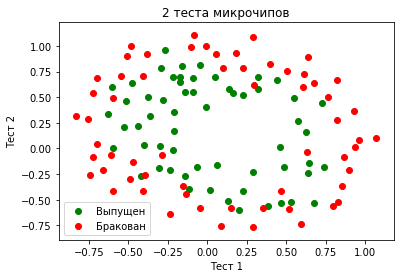

In [6]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')

plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов')

plt.legend()

Определяем функцию для отображения разделяющей кривой классификатора:

In [7]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

    # каждой точке в сетке [x_min, m_max]x[y_min, y_max] ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Создадим объект sklearn, который добавит в матрицу $X$ полиномиальные признаки вплоть до степени 7 и обучим логистическую регрессию с параметром регуляризации $C = 10^{-2}$. Изобразим разделяющую границу:

In [8]:
polyn = PolynomialFeatures(degree=7)
X_polyn = polyn.fit_transform(X)

C = 1e-2

logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_polyn, y)

/Users/mathvan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=17, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

Доля правильных ответов классификатора на обучающей выборке: 0.627


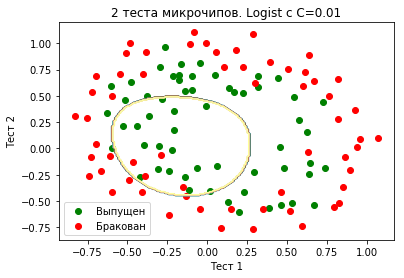

In [9]:
plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=polyn)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')

plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Logist с C=0.01')

plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_polyn, y), 3))

Видим, что регуляризация оказалась слишком сильной, и модель "недообучилась".

Увеличим $C$ до 1. Тем самым мы ослабляем регуляризацию:

In [10]:
C = 1

logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_polyn, y)

/Users/mathvan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=17, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

Доля правильных ответов классификатора на обучающей выборке: 0.831


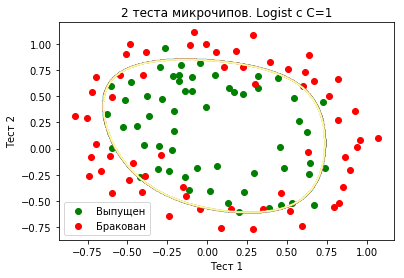

In [11]:
plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=polyn)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')

plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Logist с C=1')

plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_polyn, y), 3))

Увеличим $C$ до 10 тысяч. Теперь регуляризации явно недостаточно, и мы наблюдаем переобучение:

In [12]:
C = 1e4

logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_polyn, y)

/Users/mathvan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=17,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Доля правильных ответов классификатора на обучающей выборке: 0.873


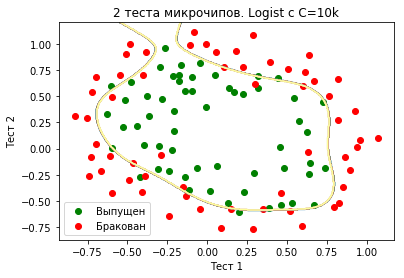

In [13]:
plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=polyn)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')

plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Logist с C=10k')

plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_polyn, y), 3))

Теперь найдем оптимальное значение параметра регуляризации $C$. Сделать это можно с помощью LogisticRegressionCV – перебора параметров по сетке с последующей кросс-валидацией. Этот класс создан специально для логистической регрессии (для нее известны эффективные алгоритмы перебора параметров):

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_polyn, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
/Users/mathvan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=array([1.00000e-02, 1.02334e-02, ..., 9.77192e+02, 1.00000e+03]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=1)

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve

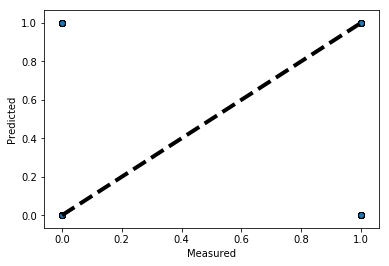

In [16]:
lr = LogisticRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X_polyn, y, cv=10)

fig, ax = plt.subplots()

ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

In [17]:
train_scores, test_scores = validation_curve(
                                            LogisticRegression(), X_polyn, y,  param_name="C",
                                            param_range=c_values, scoring="accuracy", n_jobs=-1, cv=skf
                                            )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

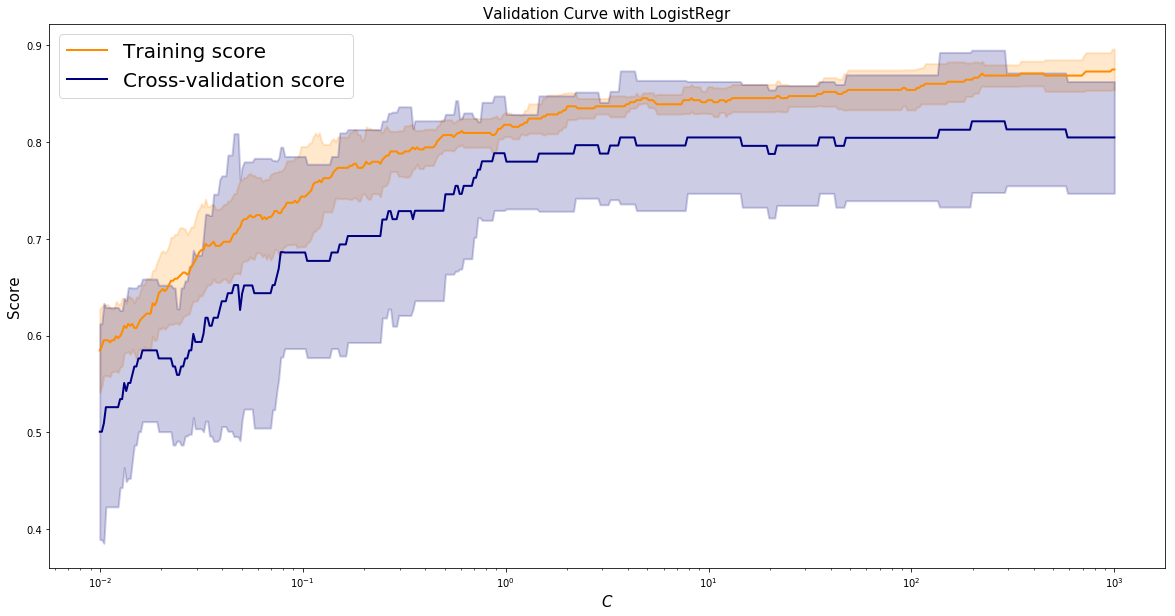

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

ax.set_title("Validation Curve with LogistRegr", fontsize = 15)
ax.set_ylabel("Score", fontsize = 15)
ax.set_xlabel(r"$C$", fontsize = 15)

lw = 2

plt.semilogx(c_values, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(c_values, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(c_values, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(c_values, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
ax.legend(fontsize = 20, loc='best')

plt.show()

---------
---------
-----

Будем решать задачу бинарной классификации отзывов IMDB к фильмам. Имеется обучающая выборка с размеченными отзывами, по 12500 отзывов известно, что они хорошие, еще про 12500 – что они плохие. Здесь уже не так просто сразу приступить к машинному обучению, потому что готовой матрицы  нет – ее надо приготовить. Будем использовать самый простой подход – мешок слов ("Bag of words"). При таком подходе признаками отзыва будут индикаторы наличия в нем каждого слова из всего корпуса, где корпус – это множество всех отзывов. Идея иллюстрируется картинкой: <img src="bagOfWords.png">

Данные [здесь](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [19]:
reviews_train = load_files("les3_linRegr/aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [20]:
text_train[4:5]

[b'If you want Scream or anything like the big-studio horror product that we get forced on us these days don\'t bother. This well-written film kept me up thinking about all it had to say. Importance of myth in our lives to make it make sense, how children interpret the world (and the violence in it), our ransacking of the environment and ignorance of its history and legends.. all here, but not flatly on the surface. You could technically call it a "monster movie" even though the Wendigo does not take physical form until the end, and then it\'s even up to you and your beliefs as to what\'s happening with the legendary spirit/beast. Some standard thriller elements for those looking just for the basics and the film never bores, though in fact the less you see of the creature, the better. Fessenden successfully continues George Romero\'s tradition of using the genre as parable and as a discussion forum while still keeping us creeped out.']

In [21]:
y_train[:5]

array([2, 2, 2, 1, 1])

In [22]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 75000
[12500 12500 50000]


In [23]:
reviews_test = load_files("les3_linRegr/aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target

print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


Составим словарь всех слов с помощью CountVectorizer. Всего в выборке 74849 уникальных слов.

In [24]:
cv = CountVectorizer()
cv.fit(text_train)

print(len(cv.vocabulary_))

124255


In [25]:
print(cv.get_feature_names()[:20])
print(cv.get_feature_names()[50000:50020])

['00', '000', '0000', '0000000000000000000000000000000001', '0000000000001', '000000001', '000000003', '00000001', '000001745', '00001', '0001', '00015', '0002', '0007', '00083', '000ft', '000s', '000th', '001', '002']
['heathen', 'heathens', 'heather', 'heatherbennett', 'heatherly', 'heathers', 'heatherton', 'heathkit', 'heathrow', 'heating', 'heatman', 'heatmiser', 'heaton', 'heats', 'heatseeker', 'heatwave', 'heave', 'heaved', 'heaven', 'heavenlier']


Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат. Преобразуем так же тестовую выборку:

In [26]:
X_train = cv.transform(text_train)
X_test = cv.transform(text_test)

Обучим логистическую регрессию и посмотрим на доли правильных ответов на обучающей и тестовой выборках:

In [27]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

print("Train:", round(logit.score(X_train, y_train), 3), "Test:", round(logit.score(X_test, y_test), 3))

/Users/mathvan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/mathvan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train: 0.944 Test: 0.196
CPU times: user 10min 59s, sys: 6.44 s, total: 11min 6s
Wall time: 5min 47s


Отобразим коэффициенты модели:

In [28]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [29]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'], color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'], color='red', label='test')

    plt.legend();

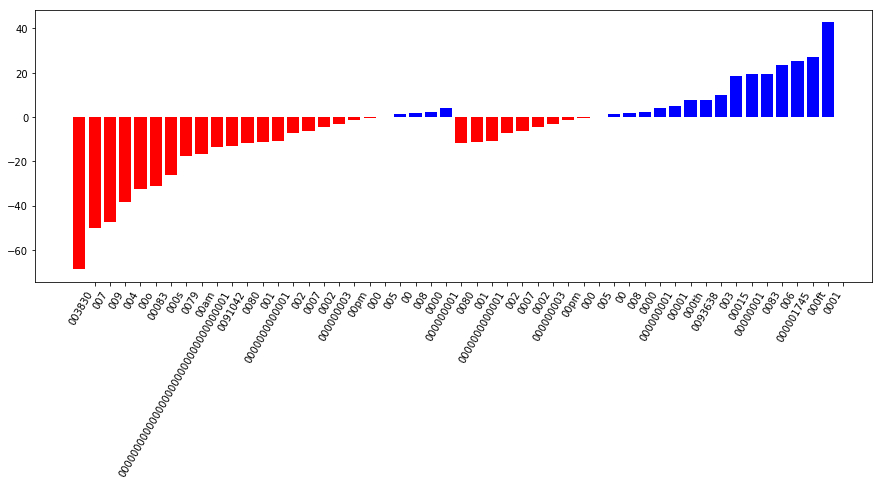

In [30]:
visualize_coefficients(logit, cv.get_feature_names())

Подберем коэффициент регуляризации для логистической регрессии. Используем sklearn.pipeline, поскольку CountVectorizer правильно применять только на тех данных, на которых в текущий момент обучается модель (чтоб не "подсматривать" в тестовую выборку и не считать по ней частоты вхождения слов). В данном случае pipeline задает последовательность действий: применить CountVectorizer, затем обучить логистическую регрессию:

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

/Users/mathvan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/mathvan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.19588


/Users/mathvan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.1312

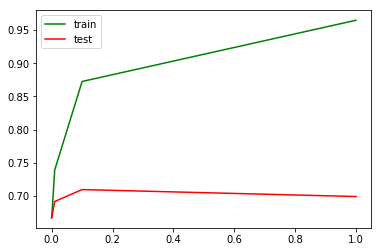

In [32]:
text_pipe_logit = make_pipeline(CountVectorizer(), LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)
grid_logit.best_params_, grid_logit.best_score_
plot_grid_scores(grid_logit, 'logisticregression__C')
grid_logit.score(text_test, y_test)

------------
--------
--------

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve

In [34]:
data = pd.read_csv('telecom_churn.csv').drop('State', axis=1)
data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1, 'No': 0})

y = data['Churn'].astype('int').values
X = data.drop('Churn', axis=1).values

Логистическую регрессию будем обучать стохастическим градиентным спуском.
<br> Построим валидационные кривые, показывающие, как качество (ROC AUC) на обучающей и проверочной выборке меняется с изменением параметра регуляризации:

In [35]:
alphas = np.logspace(-2, 0, 20)
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)

logit_pipe = Pipeline(
                    [('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), 
                    ('sgd_logit', sgd_logit)]
                     ) 
val_train, val_test = validation_curve(
                                    logit_pipe, X, y, 'sgd_logit__alpha', alphas, cv=5, scoring='roc_auc'
                                      )

In [36]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)

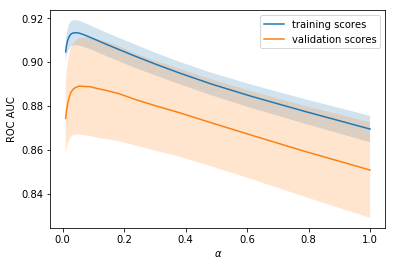

In [37]:
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$') 
plt.ylabel('ROC AUC')

plt.legend()

Тенденция видна сразу, и она очень часто встречается:

* Для простых моделей тренировочная и валидационная ошибка находятся где-то рядом, и они велики. Это говорит о том, что модель недообучилась: то есть она не имеет достаточное кол-во параметров.

* Для сильно усложненных моделей тренировочная и валидационная ошибки значительно отличаются. Это можно объяснить переобучением: когда параметров слишком много либо не хватает регуляризации, алгоритм может "отвлекаться" на шум в данных и упускать основной тренд.

Разумно поварьировать размер имеющейся обучающей выборки и посмотреть, как качество решения задачи зависит от объема данных, на котором мы обучали модель. Так получаются кривые обучения (learning curves).


Идея простая: мы отображаем ошибку как функцию от количества примеров, используемых для обучения. При этом параметры модели фиксируются заранее.


Давайте посмотрим, что мы получим для линейной модели. Коэффициент регуляризации выставим большим:

In [38]:
from sklearn.model_selection import learning_curve

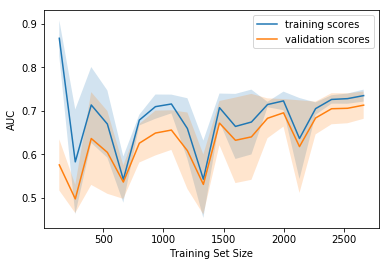

In [39]:
def plot_learning_curve(degree=2, alpha=0.01):
    train_sizes = np.linspace(0.05, 1, 20)
    
    logit_pipe = Pipeline(
                        [('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=degree)), 
                        ('sgd_logit', SGDClassifier(n_jobs=-1, random_state=17, alpha=alpha))]
                         )
    N_train, val_train, val_test = learning_curve(logit_pipe, X, y, train_sizes=train_sizes, cv=5, scoring='roc_auc')

    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    
    plt.legend()

plot_learning_curve(degree=2, alpha=10)

Типичная ситуация: для небольшого объема данных ошибки на обучающей выборке и в процессе кросс-валидации довольно сильно отличаются, что указывает на переобучение. Для той же модели, но с большим объемом данных ошибки "сходятся", что указывается на недообучение.

Если добавить еще данные, ошибка на обучающей выборке не будет расти, но с другой стороны, ошибка на тестовых данных не будет уменьшаться.

Получается, ошибки "сошлись", и добавление новых данных не поможет. Собственно, это случай – самый интересный для бизнеса. Возможна ситуация, когда мы увеличиваем выборку в 10 раз. Но если не менять сложность модели, это может и не помочь. То есть стратегия "настроил один раз – дальше использую 10 раз" может и не работать.

Что будет, если изменить коэффициент регуляризации (уменьшить до 0.05)?

<br>
Видим хорошую тенденцию – кривые постепенно сходятся, и если дальше двигаться направо (добавлять в модель данные), можно еще повысить качество на валидации.
<img src="regul=0.05.png">

А если усложнить модель ещё больше ($alpha = 10^{-4}$)?


Проявляется переобучение – AUC падает как на обучении, так и на валидации.
<img src="regul=0.0001.png">

Строя подобные кривые, можно понять, в какую сторону двигаться, и как правильно настроить сложность модели на новых данных.